# A Hands-on Introduction to Physics-Informed Neural Networks


## Authors
+ Atharva Hans
     + Graduate Research Assistant 
     + [Predictive Science Lab](https://www.predictivesciencelab.org/)
     + School of Mechanical Engineering, Purdue University
     + Email: hans1@purdue.edu
     
     
+ Ilias Bilionis
     + Associate Professor
     + [Predictive Science Lab](https://www.predictivesciencelab.org/)
     + School of Mechanical Engineering, Purdue University
     + Email: ibilion@purdue.edu


## Objectives


+ Learn how to solve ODEs with neural networks.
+ Learn how we can use neural networks to obtain simulator free solution for forward model evaluations; using a simple example from solid mechanics.
+ See how network structure affects convergence.
+ Introduce the problem of spectral bias in DNN's and see how we can solve it.

## References

+ [Artificial Neural Networks for Solving Ordinary and Partial Differential Equations](https://arxiv.org/pdf/physics/9705023.pdf)
+ [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
+ [On the Spectral Bias of Neural Networks](http://proceedings.mlr.press/v97/rahaman19a/rahaman19a.pdf)
+ [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://arxiv.org/pdf/2006.10739.pdf)


<b>If for some reason this notebook doesn't work, or is slow, you can run the notebook [here](https://colab.research.google.com/drive/1Dmbh--_YHajQgwZzXr-iYCGbMHNblB_s?usp=sharing). All you need is a google account.</b>

In [2]:
## let's import the relevant libraries
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests
import os

## check if GPU is available and use it; otherwise use CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Example 1: Single ODE

Consider the ode:
$$
\frac{d\Psi}{dx} = f(x, \Psi),
$$
with $x \in [0,1]$ and initial conditions (IC):
$$
\Psi(0) = A.
$$
We write the trial solution by:
$$
\hat{\Psi}(x; \theta) = A + x N(x; \theta),
$$
where $N(x; \theta)$ is a neural network (NN).
The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions.
The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{d\hat{\Psi}(x;\theta)}{dx} - f(x,\hat{\Psi}(x;\theta))\right]^2dx
$$

In [3]:
# N is a Neural Network - This is exactly the network used by Lagaris et al. 1997
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Initial condition
A = 0.

# The Psi_t function
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

# The loss function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

First, we will use the method that we find in [Lagaris et al](https://arxiv.org/pdf/physics/9705023.pdf).
Instead of using stochastic optimization, they use a lot of points to estimate the loss integral (We will use 100) and then they just do gradient-based optimization (We will do BFGS).

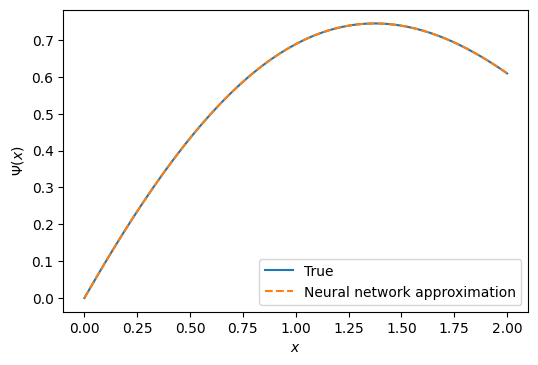

In [4]:
# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points used by Lagaris
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l
    
for i in range(10):
    optimizer.step(closure)

# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');

Now, let's use stochastic gradient descent to minimize the loss integral.

In [5]:
# We need to reinitialize the network
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Let's see now if a stochastic optimizer makes a difference
adam = torch.optim.Adam(N.parameters(), lr=0.01)

# The batch size you want to use (how many points to use per iteration)
n_batch = 5

# The maximum number of iterations to do
max_it = 1000

for i in range(max_it):
    # Randomly pick n_batch random x's:
    x = 2 * torch.rand(n_batch, 1)
    # Zero-out the gradient buffers
    adam.zero_grad()
    # Evaluate the loss
    l = loss(x)
    # Calculate the gradients
    l.backward()
    # Update the network
    adam.step()
    # Print the iteration number
    if i % 100 == 99:
        print(i+1)

100
200
300
400
500
600
700
800
900
1000


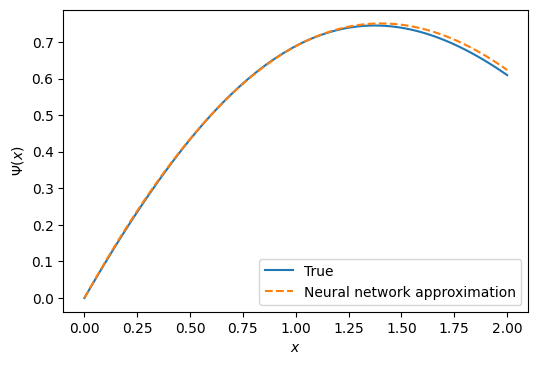

In [6]:
# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');

### Questions

+ Change `n_batch` to just 1. Does the algorithm work? Did you have to increase the iterations to achieve the same accuracy?
+ Modify the code, so that you now solve the problem for $x$ between 0 and 5. Play with the `n_batch` and `max_it` until you get a good solution.

## Example 2: Deformation of a compressible neo-Hookean material

+ Consider a neo-Hookean square body defined on $(x,y) \in [0,1]^2$. Let $u(x,y)$ describe the displacement field for this body. This body is subjected to the following displacement boundary conditions:
$$
u_x(0,y) = 0,
$$
$$
u_y(0,y) = 0,
$$
$$
u_x(1,y) = \delta,
$$
$$
u_y(1,y) = 0,
$$
with $\delta$ referring to the applied displacement along the x-direction.


+ For this hyperelastic material, the stored energy $E_b$ in the body can be expressed in as:
$$
E_b(u(x,y)) = \int_{[0,1]^2}\left\{\frac{1}{2}(\sum_{i}\sum_{j}{F_{ij}^2} - 2)- \ln(\det(F)) + 50\ln(\det(F))^2\right\} dxdy,
$$
with,
$$
F = I + \nabla u,
$$
where $I$ is an identity matrix.


+ The final orientation of this body is described by a displacement field that minimizes the stored energy $E_b$.


+ Let's describe the horizontal and the vertical components of displacement field ($u_x$ and $u_y$ respectively) for this body as:
$$
u_x(x,y) = \delta - \delta(1-x) + x(1-x)N_x(x,y;\theta),
$$
and,
$$
u_y(x,y) = x(1-x)N_y(x,y;\theta)
$$
where $N_x(x,y;\theta)$ and $N_y(x,y;\theta)$ are neural networks. Notice $u_x(x,y)$ and $u_y(x,y)$ automatically satisfies the boundary conditions. 


+ The loss function that we would like to minimize to train the NN is:
$$
L(\theta) = E_b(u(x,y))
$$
We will Monte Carlo for estimating the integral.

Next, let's define a few helper functions which will be used throughout this activity. 

### Helper Functions

##### Gradient Function

In [7]:
def grad(outputs, inputs):
    """
    This is useful for taking derivatives
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

##### Displacement Function

In [8]:
def u_r(x, delta, network1, network2, scale_network_out):
    """
    This function returns displacement field u_r.
    u_r comprises the horizontal and the vertical components 
    of displacement (u_x and u_y respectively.)
    -> x should contain the X and Y coordinates. Should be of shape: (batch size x 2)
    -> delta is the Direchlet boundary condition. Should be something similar to: torch.tensor(([right_edge_displacement, 0.]))
    """
    u_x = delta[0] - delta[0]*(1. - x[:,0][:,None]) + x[:,0][:,None]*(1. - x[:,0][:,None])*network1(x)/scale_network_out
    u_y = x[:,0][:,None]*(1. - x[:,0][:,None])*network2(x)/scale_network_out
    u_r = torch.cat((u_x, u_y), dim=1)
    return u_r 

##### Loss Function

In [9]:
def loss(X, u_r):
    """
    This is our loss function that we want to minimize.
    -> X: inputs data. Should be of shape: (batch_size x 2)
    -> Displacement function (which requires only X as input). 
    """
    X.requires_grad = True
    u_r = u_r(X)
    g_u_x = grad(u_r[:, 0], X)[:, None, :]
    g_u_y = grad(u_r[:, 1], X)[:, None, :]
    J = torch.cat([g_u_x, g_u_y], 1)
    I = torch.eye(2).repeat(X.shape[0], 1, 1)
    F = I + J
    log_det_F = torch.log(F[:, 0, 0] * F[:, 1, 1] - F[:, 0, 1] * F[:, 1, 0])
    res = (0.5 * (torch.einsum('ijk,ijk->i', F, F) - 2) - log_det_F + 50 * log_det_F ** 2)
    return torch.mean(res)

##### Training Loop

In [10]:
def train_MultiFieldFracture_seperate_net(net1, net2, right_edge_displacement, batch_size_X, max_iter, print_results_every, scale_network_out):
    """
    Trains given networks.
    -> right_edge_displacement: corresponds to boundary condition (delta) on the right edge. Example: 0.5
    -> batch_size_X: how many X's do you want to use for each iteration. Example: 10
    -> print_results_every: how often do you want to display the results. Example: 100
    """
    print('\n\nStarting training loop with seperate networks for u_x and u_y...\n\n')
    print('Right Edge Displacement: %.3f'%right_edge_displacement, '\t\tbatch_size_X: %d'%batch_size_X, '\t\tmax_iter: %d\n'%max_iter)
    network1 = net1
    network1 = network1.to(device)
    network2 = net2
    network2 = network2.to(device)
    
    # Direchlet boundary condition
    delta = torch.tensor(([right_edge_displacement, 0.]), device=device) # this contains the x and the y coordinate of the displacement applied on the body
    # Here are the parameters that we would like to optimze
    parameters = list(network1.parameters()) + list(network2.parameters())
    # Initialize the optimizer - Notice that it needs to know about the
    # parameters it it optimizing
    optimizer = torch.optim.Adam(parameters, lr=1e-4) # lr is the learning rate
    # Records time the loop starts
    start_time = perf_counter()
    # Some place to hold the training loss for visualizing it later
    loss_list = []
    elapsed_time = 0.0
    running_loss = 0.0
    for i in range(max_iter):
        X = torch.distributions.Uniform(0, 1).sample((batch_size_X, 2))
        X = X.to(device)
        # This is essential for the optimizer to keep 
        # track of the gradients correctly 
        # It is using some buffers internally that need to 
        # be manually zeroed on each iteration.
        # This is because the optimizer doesn't know when you are done with the
        # calculation of the loss.
        optimizer.zero_grad()
        # Evaluate the loss - That's what you are minimizing
        l = loss(X, partial(u_r, delta=delta, network1=network1, network2=network2, scale_network_out=scale_network_out))
        # Add the loss to the running loss
        running_loss += l.item()
        # Evaluate the derivative of the loss with respect to
        # all parameters
        l.backward()
        # And now you are ready to make a step
        optimizer.step()
        if (i+1)%print_results_every == 0:
            # Print loss, time elapsed every "print_results_every"# iterations
            current_time = perf_counter()
            elapsed_time = current_time - start_time 
            print('[iter: %d]'%(i+1), '\t\telapsed_time: %3d secs'%elapsed_time, '\t\tLoss: ', running_loss/print_results_every)
            loss_list.append(running_loss/print_results_every)
            running_loss = 0.0
            
    return loss_list, network1, network2

##### Model Capacity

In [11]:
def model_capacity(net):
    """
    Prints the number of parameters and the number of layers in the network
    -> Requires a neural network as input
    """
    number_of_learnable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    num_layers = len(list(net.parameters()))
    print("\nThe number of layers in the model: %d" % num_layers)
    print("The number of learnable parameters in the model: %d\n" % number_of_learnable_params)  

##### Plots

In [12]:
def plot_loss(loss, label):
    """
    Plots the loss function.
    -> loss: list containing the losses
    -> label: label for this loss
    """
    ax.plot(100*np.arange(len(loss)), loss, label='%s'%label)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    plt.legend(loc='best')
    
    
def plot_displacement(network1, network2,
                      right_edge_displacement,
                      scale_network_out,
                      num_samples_X = 200, s = 4,
                      ):
    
    """
    Plots the horizontal and vertical components of displacements at given number of points.
    -> network1: neural network 1
    -> network2: neural network 2
    -> right_edge_displacement: corresponds to boundary condition (delta) on the right edge. Example: 0.5
    -> num_samples_X: number of grid points
    -> s: Marker size
    """
    
    ## Direchlet Boundary condition
    delta = torch.tensor(([right_edge_displacement, 0.])) # this contains the x and the y coordinate of the displacement applied on the body    
    
    for i in range(1):
        figure, ax = plt.subplots(1,2, figsize=(20,5))
        
        X_init = torch.linspace(0, 1, num_samples_X)
        xx, yy = torch.meshgrid(X_init, X_init)
        X_init = torch.cat((xx.reshape(-1)[:,None], yy.reshape(-1)[:,None]), axis=1)

        displacement = u_r(X_init, delta, network1, network2, scale_network_out).detach().numpy()
        X_final_dual = X_init + displacement 
        X_final_dual = X_final_dual.numpy()
    
        sc1 = ax[0].scatter(X_final_dual[:,0], X_final_dual[:,1], s=s, c = displacement[:,0], cmap=plt.cm.get_cmap('copper'))
        plt.colorbar(sc1, ax=ax[0])
        ax[0].set_title('Horiontal Displacement ($u_x$)')
    
        sc2 = ax[1].scatter(X_final_dual[:,0], X_final_dual[:,1], s=s, c = displacement[:,1], cmap=plt.cm.get_cmap('copper'))
        plt.colorbar(sc2, ax=ax[1])
        ax[1].set_title('Vertical Displacement ($u_y$)')
    
        plt.tight_layout()        

Let's start with displacement ($\delta$) of 0.5, so
$$
u_x(1,y) = 0.5.
$$

<b>Note: Solving this problem for displacement ($\delta$) of 0.5 in FEM requires us to break down displacement in smaller chunks. For example, we would first solve for the displacement field for $\delta=0.1$ then using that displacement field as baseline, we would further solve it for $\delta=0.1$ and so on...(until we reach $\delta=0.5$).

In general, FEM solver fails when we try solving for the displacement ($\delta$) of 0.5 at once.</b> 

In [13]:
# Boundary condition (delta) on the right edge
right_edge_displacement = 0.5 # try 0.05
# Scale down the network output to ensure we get +ve determinant of the Jacobian.
# We have to scale the output so that as the training begins we don't initialize a displacement 
# which has no physical meaning. 
# For example, the determinant of the Jacobian cannot be negative 
# since that would mean negative volume; which has no physical meaning. 
scale_network_out = 5 

### Part A: Simple Fully Connected Neural Network

Let's begin with a simplest case where we have simple fully connected neural networks for both the horizontal displacement $u_x$ and the vertical displacement $u_y$.

##### Define Model

In [14]:
# here is the network for the u_x
simple_net1 = nn.Sequential(nn.Linear(2,50), 
                     nn.Sigmoid(), 
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,1)
                    )

# here is the network for the u_y
simple_net2 = nn.Sequential(nn.Linear(2,50), 
                     nn.Sigmoid(), 
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,50), 
                     nn.Sigmoid(),
                     nn.Linear(50,1)
                    )

# here is how we can find the number of layers and number of model parameters in each network
model_capacity(simple_net1)
model_capacity(simple_net2)


The number of layers in the model: 16
The number of learnable parameters in the model: 15501


The number of layers in the model: 16
The number of learnable parameters in the model: 15501



Here is just a sanity check that we start from a candidate solution that indeed satisfies the boundary conditions:

e:\project\python\venv3.9\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


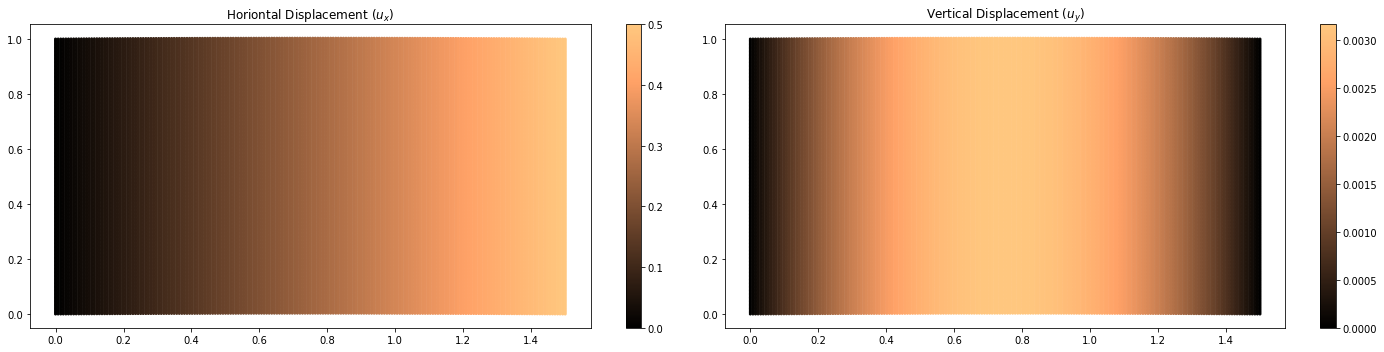

In [15]:
plot_displacement(simple_net1, simple_net2,
                  right_edge_displacement, scale_network_out)

##### Train Model

Let's train the network for 5000 iterations and batch size of 10. Training should take around 6-8 minutes.

In [16]:
loss_list_simple_net, simple_net1, simple_net2 = train_MultiFieldFracture_seperate_net(net1=simple_net1, net2=simple_net2, 
                                                                      right_edge_displacement = right_edge_displacement, 
                                                                      batch_size_X = 10, 
                                                                      max_iter = 5000, 
                                                                      print_results_every = 100, scale_network_out=scale_network_out)



Starting training loop with seperate networks for u_x and u_y...


Right Edge Displacement: 0.500 		batch_size_X: 10 		max_iter: 5000

[iter: 100] 		elapsed_time:   1 secs 		Loss:  8.421093797683715
[iter: 200] 		elapsed_time:   2 secs 		Loss:  8.444573845863342
[iter: 300] 		elapsed_time:   4 secs 		Loss:  8.371694345474243
[iter: 400] 		elapsed_time:   5 secs 		Loss:  7.336328706741333
[iter: 500] 		elapsed_time:   7 secs 		Loss:  4.413229682445526
[iter: 600] 		elapsed_time:   8 secs 		Loss:  3.1060577309131623
[iter: 700] 		elapsed_time:   9 secs 		Loss:  2.9965335166454317
[iter: 800] 		elapsed_time:  10 secs 		Loss:  2.82574649810791
[iter: 900] 		elapsed_time:  11 secs 		Loss:  2.806174238920212
[iter: 1000] 		elapsed_time:  12 secs 		Loss:  2.6458054006099703
[iter: 1100] 		elapsed_time:  13 secs 		Loss:  2.6486253809928892
[iter: 1200] 		elapsed_time:  14 secs 		Loss:  2.5757436978816988
[iter: 1300] 		elapsed_time:  16 secs 		Loss:  2.512390276193619
[iter: 1400] 		elapsed_

##### Analyze Training Loss and Material Displacement

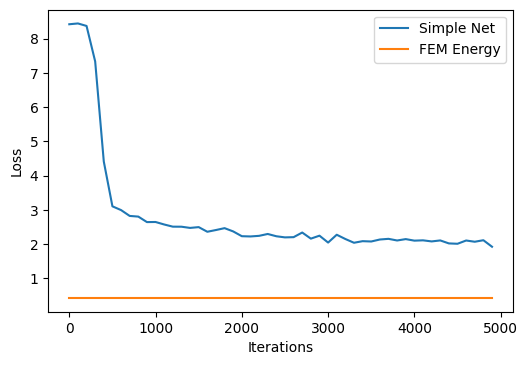

In [17]:
# Let's visualize the training loss
figure, ax = plt.subplots(dpi=100)
plot_loss(loss_list_simple_net, 'Simple Net')

if right_edge_displacement==0.05:
    ax.plot(100*np.arange(len(loss_list_simple_net)), 0.006*np.ones(len(loss_list_simple_net)), label='FEM Energy')
elif right_edge_displacement==0.5:
    ax.plot(100*np.arange(len(loss_list_simple_net)), 0.43*np.ones(len(loss_list_simple_net)), label='FEM Energy')
plt.legend(loc='best'); 

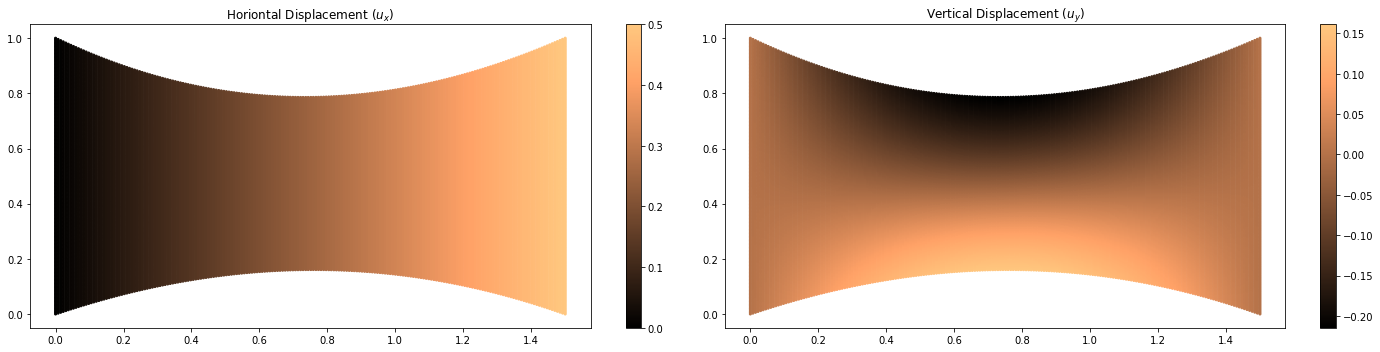

In [18]:
# Let's visualize the body post-training
plot_displacement(simple_net1, simple_net2, right_edge_displacement, scale_network_out)

The above loss might or might not converge (to the FEM solution) depending on the number of iterations we trained the network and on the boundary displacement that we choose. If we run it long enough (~20,000 iterations), it might converge. 

Unlike the first example, where we were trying to solve a simple ODE (and the neural network wasn't very deep), here we have relatively deeper networks which may pose two issues:
+ [Vanishing gradients](https://arxiv.org/pdf/1512.03385.pdf)
+ [Bias towards lower frequency functions](http://proceedings.mlr.press/v97/rahaman19a/rahaman19a.pdf)

Is there anything we can do to speed up the convergence?

### Part B: ResNet Architecture 

In this part let's introduce a ResNet architecture for our neural networks and investigate if we get better convergence. 
ResNet architecture includes skip-connections between the layers which has been [shown](https://arxiv.org/pdf/1512.03385.pdf) to overcome the vanishing gradient problem (and help with convergence).

Figure 1a below shows a schematic of a deep ResNet with a dense input layer, followed by K residual blocks and an output layer. 

Figure 1b shows s single residual block with L layers. Pay attention to how we have a skip-connection from the input $z^{(i-1,0)}$ to the output $z^{(i,0)}$. The skip connections lead to better backpropagation of the loss and helps in better convergence. 

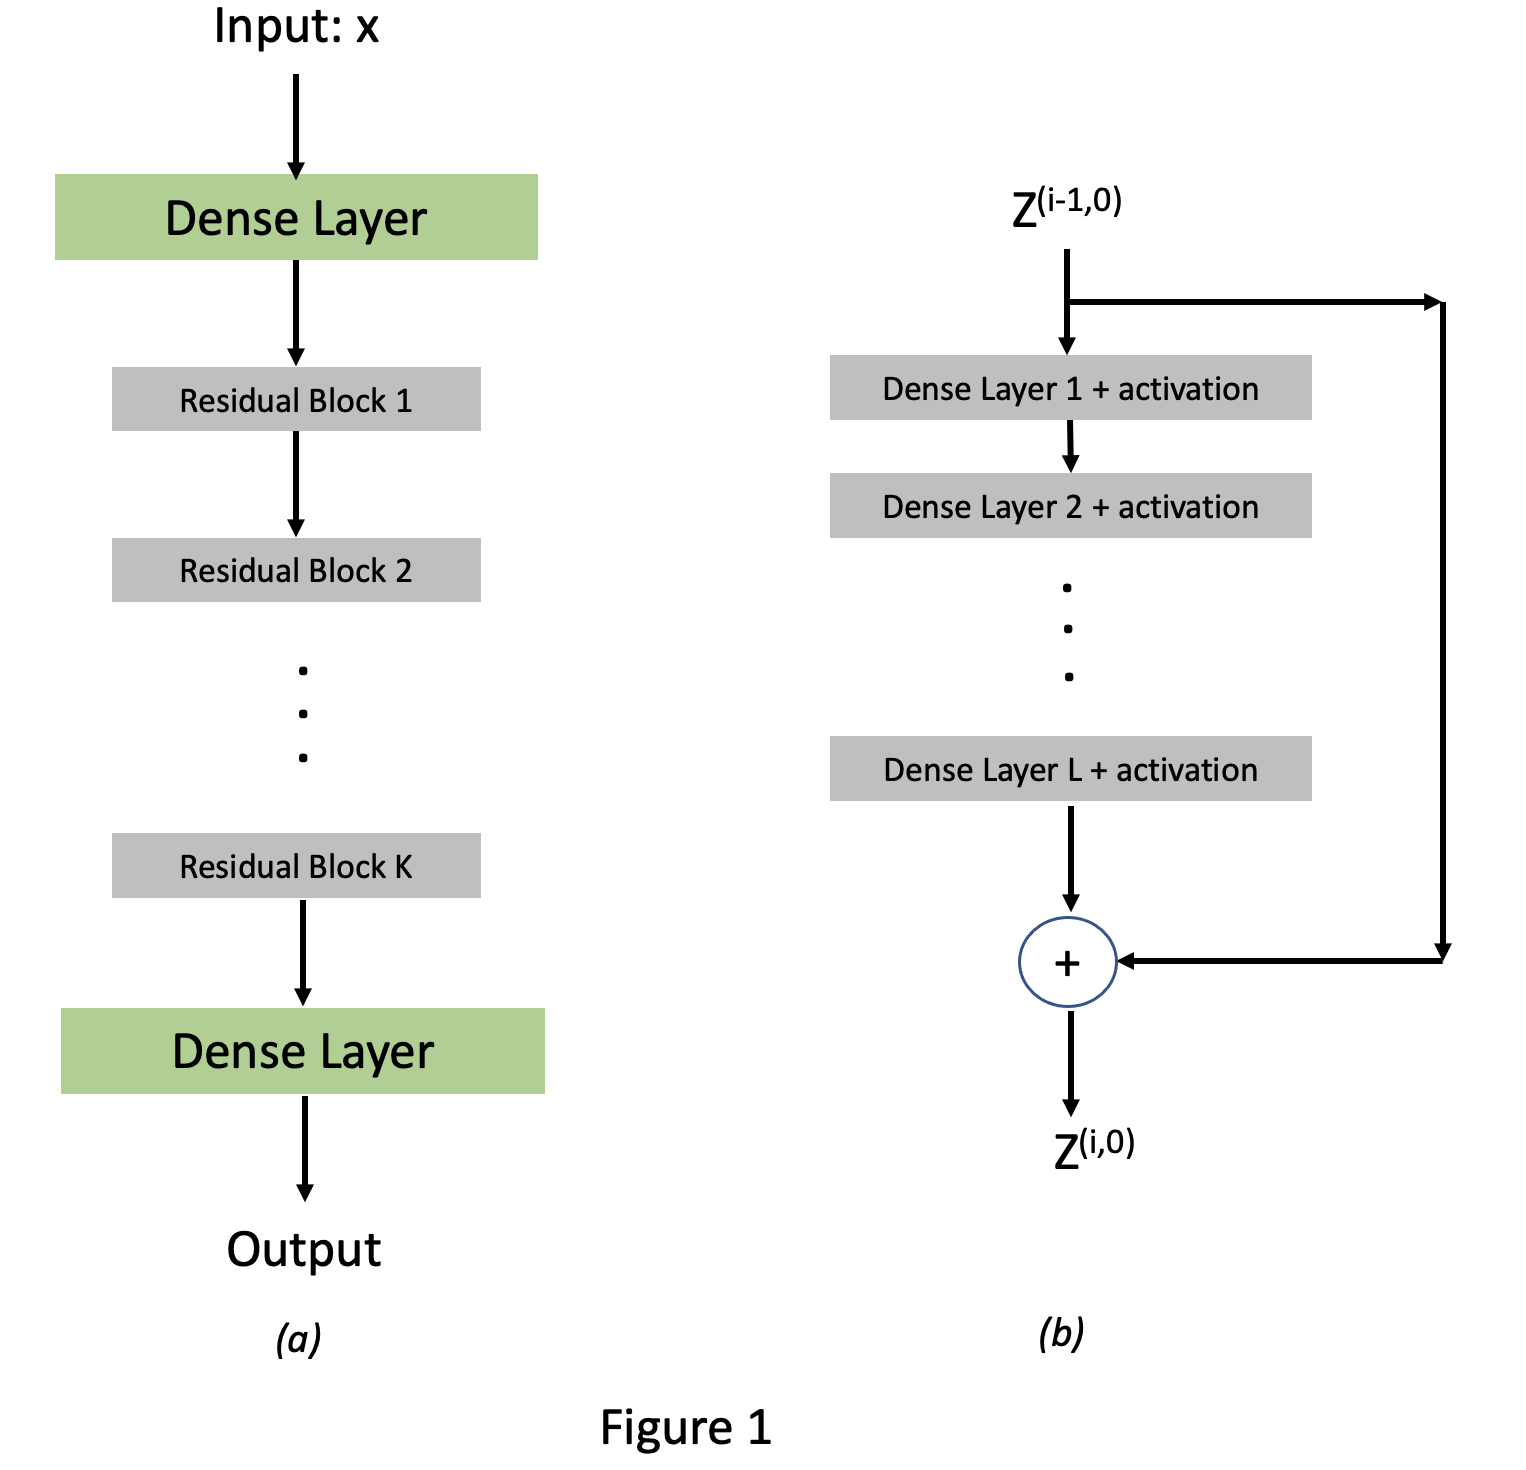

In [19]:
# schematic of a deep ResNet
Image.open('ResNet.png')

Here is a `DenseResNet` class:

In [20]:
class DenseResNet(nn.Module):
    """
    This is a ResNet Class.
    -> dim_in: network's input dimension
    -> dim_out: network's output dimension
    -> num_resnet_blocks: number of ResNet blocks
    -> num_layers_per_block: number of layers per ResNet block
    -> num_neurons: number of neurons in each layer
    -> activation: Non-linear activations function that you want to use. E.g. nn.Sigmoid(), nn.ReLU()
    -> fourier_features: whether to pass the inputs through Fourier mapping. E.g. True or False
    -> m_freq: how many frequencies do you want the inputs to be mapped to
    -> sigma: controls the spectrum of frequencies. 
              If sigma is greater more frequencies are consider. 
              You can also look at it as sampling from the standard normal, Z~N(0, 1), 
              and mapping to another normal, X~N(\mu, \sigma^2), using x = mu + sigma*z.
    -> tune_beta: do you want to consider the parameter beta in the activation functions in each layer? E.g., Tanh(beta*x).
                  In practice it is observed that training beta (i.e. tune_beta=True) could improve convergence. 
                  If tune_beta=False, you get the a fixed beta i.e. beta=1.
    -> The method model_capacity() returns the number of layers and parameters in the network.
    """
    def __init__(self, dim_in=2, dim_out=1, num_resnet_blocks=3, 
                 num_layers_per_block=2, num_neurons=50, activation=nn.Sigmoid(), 
                 fourier_features=False, m_freqs=100, sigma=10, tune_beta=False):
        super(DenseResNet, self).__init__()

        self.num_resnet_blocks = num_resnet_blocks
        self.num_layers_per_block = num_layers_per_block
        self.fourier_features = fourier_features
        self.activation = activation
        self.tune_beta = tune_beta

        if tune_beta:
            self.beta0 = nn.Parameter(torch.ones(1, 1))
            self.beta = nn.Parameter(torch.ones(self.num_resnet_blocks, self.num_layers_per_block))

        else: 
            self.beta0 = torch.ones(1, 1)
            self.beta = torch.ones(self.num_resnet_blocks, self.num_layers_per_block)

        self.first = nn.Linear(dim_in, num_neurons)

        self.resblocks = nn.ModuleList([
            nn.ModuleList([nn.Linear(num_neurons, num_neurons) 
                for _ in range(num_layers_per_block)]) 
            for _ in range(num_resnet_blocks)])

        self.last = nn.Linear(num_neurons, dim_out)

        if fourier_features:
            self.first = nn.Linear(2*m_freqs, num_neurons)
            self.B = nn.Parameter(sigma*torch.randn(dim_in, m_freqs)) # to converts inputs to m_freqs

    def forward(self, x):
        if self.fourier_features:
            cosx = torch.cos(torch.matmul(x, self.B))
            sinx = torch.sin(torch.matmul(x, self.B))
            x = torch.cat((cosx, sinx), dim=1)
            x = self.activation(self.beta0*self.first(x)) 

        else:
            x = self.activation(self.beta0*self.first(x))

        for i in range(self.num_resnet_blocks):
            z = self.activation(self.beta[i][0]*self.resblocks[i][0](x))

            for j in range(1, self.num_layers_per_block):
                z = self.activation(self.beta[i][j]*self.resblocks[i][j](z))

            x = z + x

        out = self.last(x)

        return out

    def model_capacity(self):
        """
        Prints the number of parameters and the number of layers in the network
        """
        number_of_learnable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        num_layers = len(list(self.parameters()))
        print("\n\nThe number of layers in the model: %d" % num_layers)
        print("\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)  

##### Define Model

In [21]:
dense_net1 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=3, 
                        num_layers_per_block=2, num_neurons=50, activation=nn.Sigmoid(), 
                        fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)

dense_net2 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=3, 
                        num_layers_per_block=2, num_neurons=50, activation=nn.Sigmoid(), 
                        fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)

# Here is the model capacity:
model_capacity(dense_net1)
model_capacity(dense_net2)


The number of layers in the model: 16
The number of learnable parameters in the model: 15501


The number of layers in the model: 16
The number of learnable parameters in the model: 15501



<b>Pay attention: We have the same number of parameters as in Part A</b>. Only difference now is that the network has a ResNet architecture (allows better back propagation of loss). Let's train this model and see if this helps in convergence.

Here is just a sanity check that we start from a candidate solution that indeed satisfies the boundary conditions:

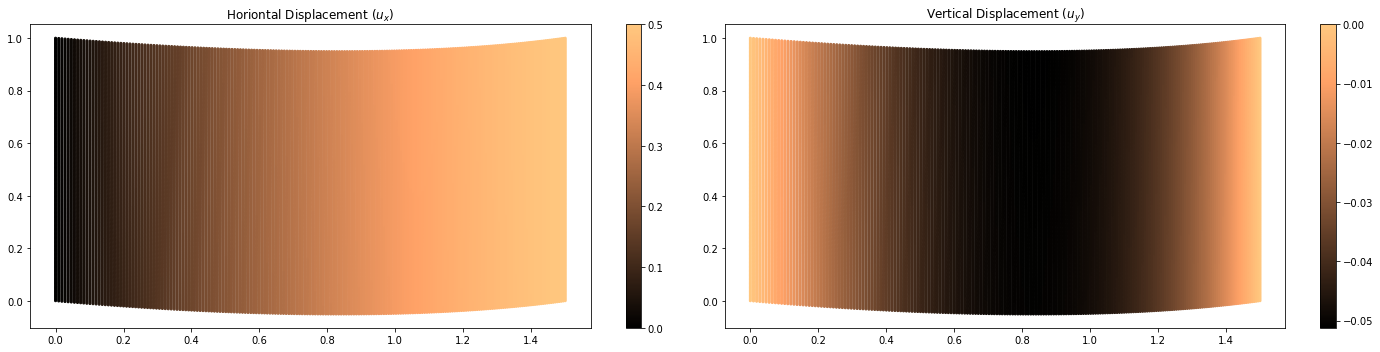

In [22]:
# Let's visualize the body pre-training and make sure the boundary conditions are satified
plot_displacement(dense_net1, dense_net2, right_edge_displacement, scale_network_out)

##### Train Model

Let's train the network for 5000 iterations and batch size of 10. Training should take around 6-8 minutes.

In [23]:
loss_list_dense, dense_net1, dense_net2 = train_MultiFieldFracture_seperate_net(net1=dense_net1, net2=dense_net2, 
                                                                      right_edge_displacement = right_edge_displacement, 
                                                                      batch_size_X = 10, 
                                                                      max_iter = 5000, 
                                                                      print_results_every = 100, scale_network_out=scale_network_out)



Starting training loop with seperate networks for u_x and u_y...


Right Edge Displacement: 0.500 		batch_size_X: 10 		max_iter: 5000

[iter: 100] 		elapsed_time:   1 secs 		Loss:  8.55447964668274
[iter: 200] 		elapsed_time:   3 secs 		Loss:  8.392198781967164
[iter: 300] 		elapsed_time:   4 secs 		Loss:  7.97453004360199
[iter: 400] 		elapsed_time:   6 secs 		Loss:  7.283066110610962
[iter: 500] 		elapsed_time:   7 secs 		Loss:  5.547060995101929
[iter: 600] 		elapsed_time:   9 secs 		Loss:  3.110290937423706
[iter: 700] 		elapsed_time:  10 secs 		Loss:  2.299704753160477
[iter: 800] 		elapsed_time:  11 secs 		Loss:  2.1109620678424834
[iter: 900] 		elapsed_time:  13 secs 		Loss:  2.0505902445316315
[iter: 1000] 		elapsed_time:  14 secs 		Loss:  2.215421382188797
[iter: 1100] 		elapsed_time:  15 secs 		Loss:  2.0396581292152405
[iter: 1200] 		elapsed_time:  16 secs 		Loss:  2.1598744815588
[iter: 1300] 		elapsed_time:  17 secs 		Loss:  2.070562663078308
[iter: 1400] 		elapsed_time:

##### Analyze Training Loss and Material Displacement

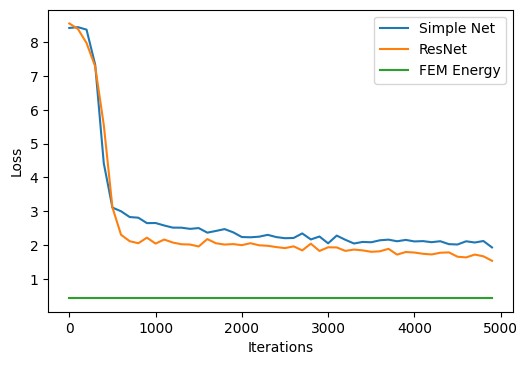

In [24]:
# Let's visualize the training loss
figure, ax = plt.subplots(dpi=100)
plot_loss(loss_list_simple_net, 'Simple Net')
plot_loss(loss_list_dense, 'ResNet')

if right_edge_displacement==0.05:
    ax.plot(100*np.arange(len(loss_list_dense)), 0.006*np.ones(len(loss_list_dense)), label='FEM Energy')
elif right_edge_displacement==0.5:
    ax.plot(100*np.arange(len(loss_list_dense)), 0.43*np.ones(len(loss_list_dense)), label='FEM Energy')
plt.legend(loc='best');

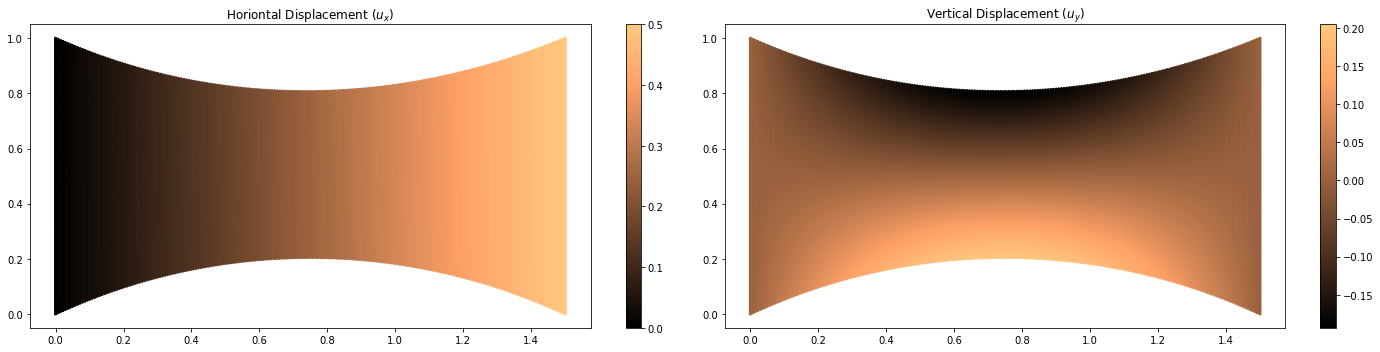

In [25]:
# Let's visualize the body post-training
plot_displacement(dense_net1, dense_net2, right_edge_displacement, scale_network_out)

Using ResNet architecture seems to have improved the convergence as compared to the case of the simple network in part A. 

One reason for this is as we make the network deeper, it can hurt the ability to train the network to do well on the training set. ResNet overcomes this issue by introducing skip connections between layers; this helps better backpropagation of loss and better convergence.

Can we further improve this?

### Part C: Fourier Features

In this part let's not only use a ResNet architecture for our neural networks but also introduce a Fourier feature mapping for the input data. 
It has been observed that deeper networks are biased towards low frequency functions (["Over-parameterized networks prioritize learning simple patterns that generalize
across data samples"](http://proceedings.mlr.press/v97/rahaman19a/rahaman19a.pdf)). 

To solve this bias towards the low frequency function, [Tancik et al.](https://arxiv.org/pdf/2006.10739.pdf) show that passing the neural network inputs through a simple Fourier feature mapping not only helps neural network learn high-frequency function, but also, helps achieve faster convergence for high frequency components.  

The create a neural network with Fourier feature, just set the parameter `fourier_features` as `True` in the `DenseResNet` class I defined above:

##### Define Model

In [26]:
Fourier_dense_net1 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=3, 
                        num_layers_per_block=2, num_neurons=50, activation=nn.Sigmoid(), 
                        fourier_features=True, m_freqs=100, sigma=10, tune_beta=False)

Fourier_dense_net2 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=3, 
                        num_layers_per_block=2, num_neurons=50, activation=nn.Sigmoid(), 
                        fourier_features=True, m_freqs=100, sigma=10, tune_beta=False)

# Here is the model capacity:
model_capacity(Fourier_dense_net1)
model_capacity(Fourier_dense_net2)


The number of layers in the model: 17
The number of learnable parameters in the model: 25601


The number of layers in the model: 17
The number of learnable parameters in the model: 25601



Here is just a sanity check that we start from a candidate solution that indeed satisfies the boundary conditions:

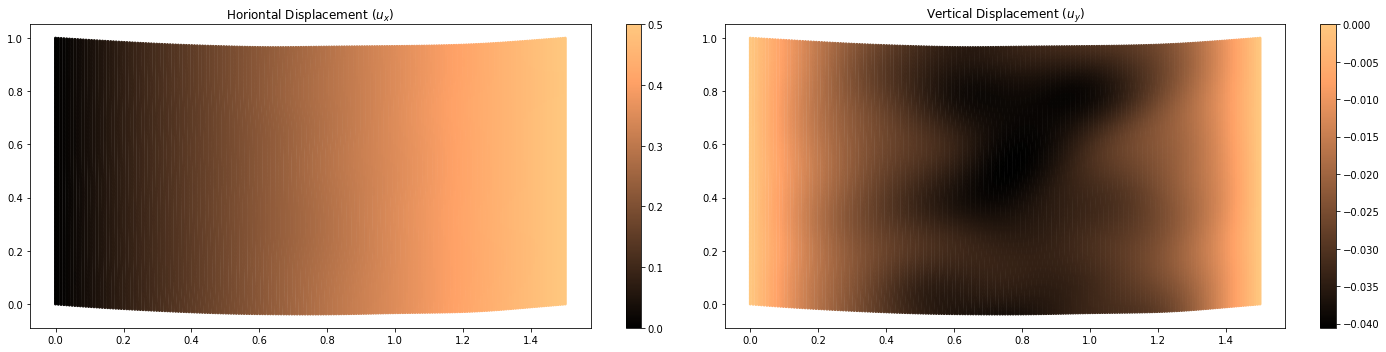

In [28]:
# Let's visualize the body pre-training and make sure the boundary conditions are satified
plot_displacement(Fourier_dense_net1, Fourier_dense_net2, right_edge_displacement, scale_network_out)

##### Train Model

Let's train the network for 5000 iterations and batch size of 10. Training should take around 6-8 minutes.

In [29]:
# Now, let's train the network
loss_list_dense_fourier, Fourier_dense_net1, Fourier_dense_net2 = train_MultiFieldFracture_seperate_net(net1=Fourier_dense_net1, 
                                                                                                     net2=Fourier_dense_net2, 
                                                                                                     right_edge_displacement = right_edge_displacement, 
                                                                                                     batch_size_X = 10, 
                                                                                                     max_iter = 5000, 
                                                                                                     print_results_every = 100, scale_network_out=scale_network_out)



Starting training loop with seperate networks for u_x and u_y...


Right Edge Displacement: 0.500 		batch_size_X: 10 		max_iter: 5000

[iter: 100] 		elapsed_time:   1 secs 		Loss:  8.454360303878785
[iter: 200] 		elapsed_time:   3 secs 		Loss:  8.104327530860902
[iter: 300] 		elapsed_time:   5 secs 		Loss:  7.711361002922058
[iter: 400] 		elapsed_time:   7 secs 		Loss:  7.150759010314942
[iter: 500] 		elapsed_time:   9 secs 		Loss:  6.013229475021363
[iter: 600] 		elapsed_time:  10 secs 		Loss:  3.8486704349517824
[iter: 700] 		elapsed_time:  11 secs 		Loss:  2.634987571835518
[iter: 800] 		elapsed_time:  13 secs 		Loss:  2.110650516748428
[iter: 900] 		elapsed_time:  14 secs 		Loss:  1.7134597635269164
[iter: 1000] 		elapsed_time:  16 secs 		Loss:  1.4172395086288452
[iter: 1100] 		elapsed_time:  17 secs 		Loss:  1.380752112865448
[iter: 1200] 		elapsed_time:  18 secs 		Loss:  1.304535050392151
[iter: 1300] 		elapsed_time:  20 secs 		Loss:  1.0600083088874817
[iter: 1400] 		elapsed_

##### Analyze Training Loss and Material Displacement

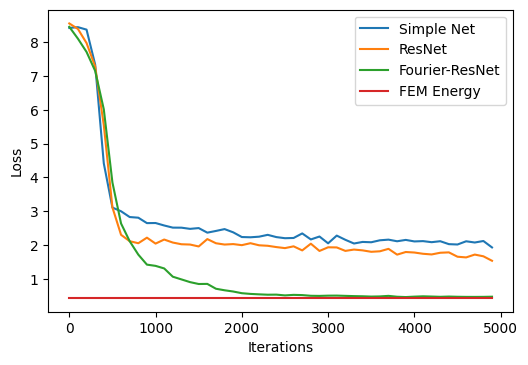

In [30]:
# Let's visualize the training loss
figure, ax = plt.subplots(dpi=100)
plot_loss(loss_list_simple_net, 'Simple Net')
plot_loss(loss_list_dense, 'ResNet')
plot_loss(loss_list_dense_fourier, 'Fourier-ResNet')

if right_edge_displacement==0.05:
    ax.plot(100*np.arange(len(loss_list_dense)), 0.006*np.ones(len(loss_list_dense)), label='FEM Energy')
elif right_edge_displacement==0.5:
    ax.plot(100*np.arange(len(loss_list_dense)), 0.43*np.ones(len(loss_list_dense)), label='FEM Energy')

plt.legend(loc='best');

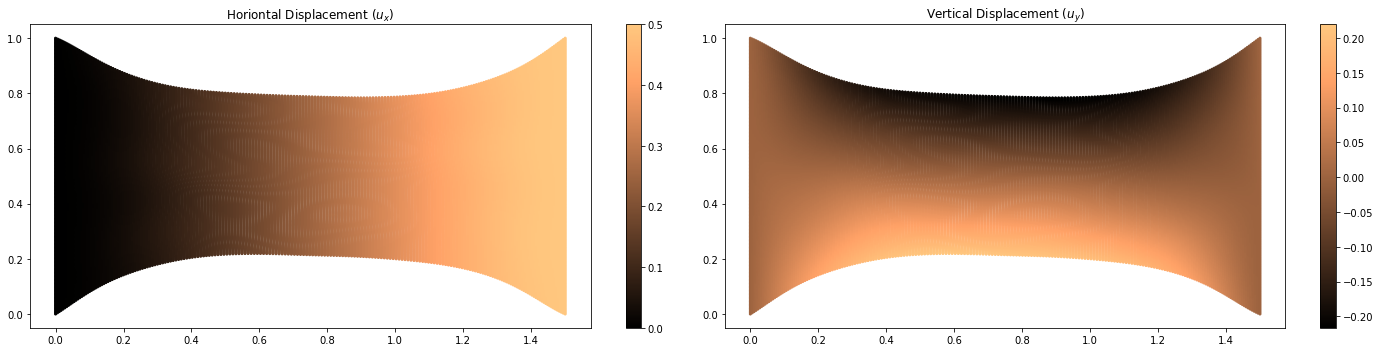

In [31]:
# Let's visualize the body post-training
plot_displacement(Fourier_dense_net1, Fourier_dense_net2, right_edge_displacement, scale_network_out)

This look great! The loss seems to have converged to the FEM solution. 

### Questions

+ For part A, rerun the code for 20,000 iterations. Does the simple network in part A converge? How does the prediction look?
+ How does batch size affect the convergence? Try different batch sizes (20, 40,...) by changing `batch_size_X` in the `train_MultiFieldFracture_seperate_net` function. Which one works the best? 
+ Change the activation function in the `DenseResNet` class from `nn.Sigmoid()` to `nn.ReLU()` and rerun the code. How does the convergence change?
+ In the `DenseResNet` class, read the docstring to see what `tune_beta=True` does. Set `tune_beta=True` and rerun the code. Do you observe better convergence?